## Import Package & Setting

In [1]:
import re
import pickle
import glob
import gdown
import zipfile
import matplotlib.pyplot as plt

In [2]:
# connect to google dirve
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!rm -r ./sample_data

## Get Model and Dataset

### Model Source Code

In [4]:
!cp /gdrive/MyDrive/Classical_Music_Transformer_Integration/data/pretrained_model/classical_music_transformer/* ./

cp: -r not specified; omitting directory '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/pretrained_model/classical_music_transformer/inference'


### Download BPS Dataset

In [5]:
with zipfile.ZipFile("/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/bps_fh_data/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("")
!mv ./functional-harmony-master/BPS_FH_Dataset ./BPS_FH_Dataset
!rm -r ./functional-harmony-master/

### Download Your Own Dataset

In [10]:
paths = glob.glob('/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/*')

In [11]:
paths = paths[0:]

In [12]:
paths

['/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/02-髮如雪',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/03-簡單愛',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/04-不能說的秘密',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/05-七里香',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/07-菊花台',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/09-她的睫毛',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/06-擱淺',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/01-藉口',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/08-陽光宅男',
 '/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/preprocessed_data/Jay/10-黑色毛衣']

In [13]:
idx = 33

print('All Music: {}'.format(str(len(paths))))
for path in paths:
    song = path.split('/')[-1]
    print(song + " => " + str(idx))

    dest = "/content/BPS_FH_Dataset/" + str(idx)
    !cp -r $path $dest

    idx += 1

All Music: 10
02-髮如雪 => 33
03-簡單愛 => 34
04-不能說的秘密 => 35
05-七里香 => 36
07-菊花台 => 37
09-她的睫毛 => 38
06-擱淺 => 39
01-藉口 => 40
08-陽光宅男 => 41
10-黑色毛衣 => 42


## Data Preprocess

In [ ]:
total_song = idx - 1

### Helper Function

In [ ]:
import xlrd
import math
import numpy as np
import numpy.lib.recfunctions as rfn
from settings import *

class Item(object):
    def __init__(self, name, start, end, pitch, dur, chord, tone):
        self.name = name
        self.start = start
        self.end = end
        self.pitch = pitch
        self.dur = dur
        self.chord = chord
        self.tone = tone
       
    def __repr__(self):
        return 'Item(name={}, start={}, end={}, pitch={}, chord={}, dur={}, tone={})'.format(
            self.name, self.start, self.end, self.pitch, self.chord, self.dur, self.tone)

def r2tconvert(chords):
    """
    Translate roman numeral representations  into chord symbols, and add chord symbols into chord labels.
    :param chords:
    :return: rtchords
    """

    # Create scales of all keys
    temp = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
    keys = {}
    for i in range(11):
        majtonic = temp[(i*4)%7] + int(i/7)*'+' + int(i%7>5)*'+'
        mintonic = temp[(i*4-2)%7].lower() + int(i/7)*'+' + int(i%7>2)*'+'

        scale = list(temp)
        for j in range(i):
            scale[(j+1)*4%7-1] += '+'
        majscale = scale[(i*4)%7:] + scale[:(i*4)%7]
        minscale = scale[(i*4+5)%7:] + scale[:(i*4+5)%7]
        minscale[6] += '+'
        keys[majtonic] = majscale
        keys[mintonic] = minscale

    for i in range(1, 9):
        majtonic = temp[(i*3)%7] + int(i/7)*'-' + int(i%7>1)*'-'
        mintonic = temp[(i*3-2)%7].lower() + int(i/7)*'-' + int(i%7>4)*'-'

        scale = list(temp)
        for j in range(i):
            scale[(j+2)*3%7] += '-'
        majscale = scale[(i*3)%7:] + scale[:(i*3)%7]
        minscale = scale[(i*3+5)%7:] + scale[:(i*3+5)%7]
        if len(minscale[6]) == 1:
            minscale[6] += '+'
        else:
            minscale[6] = minscale[6][:-1]

        keys[majtonic] = majscale
        keys[mintonic] = minscale

    # Translate chords
    outputQ = {'M':'M', 'm':'m', 'M7':'M7', 'm7':'m7', 'D7':'7', 'a':'aug', 'd':'dim', 'd7':'dim7', 'h7':'m7(b5)','a6':'7'}
    tchords = []
    for idx, rchord in enumerate(chords):
        #print(rchord)
        
        key = str(rchord['key'])
        print(f'{idx+1}: {key}')
        str_degree = str(rchord['degree'])

        if '/' not in str_degree: # case: not secondary chord
            if len(str_degree) == 1: # case: degree = x
                degree = int(float(str_degree))
                root = keys[key][degree-1]
            elif len(str_degree) == 2 and ('+' in str_degree[0] or '-' in str_degree[0]): # case: degree = -x or +x
                if str(rchord['quality']) != 'a6': # case: chromatic chord, -x
                    degree = int(float(str_degree[1]))
                    root = keys[key][abs(degree)-1]
                    if '+' not in root:
                        root += str_degree[0]
                    else:
                        root = root[:-1]
                else: # case: augmented 6th
                    degree = 6
                    root = keys[key][degree-1]
                    if str(rchord['key'])[0].isupper(): # case: major key
                        if '+' not in root:
                            root += '-'
                        else:
                            root = root[:-1]
            elif len(str_degree) == 2 and ('+' in str_degree[1] or '-' in str_degree[1]): # case: degree = x+
                degree = int(float(str_degree[0]))
                root = keys[key][degree - 1]

        elif '/' in str_degree: # case: secondary chord
            degree = str_degree
            if '+' not in degree.split('/')[0]:
                n = int(degree.split('/')[0]) # numerator
            else:
                n = 6
            d = int(degree.split('/')[1]) # denominator
            if d > 0:
                key2 = keys[key][d-1] # secondary key
            else:
                key2 = keys[key][abs(d)-1] # secondary key
                if '+' not in key2:
                    key2 += '-'
                else:
                    key2 = key2[:-1]

            if '+' in degree.split('/')[0]:
                n = 6


            if key2 == 'F++':
                print('Convert F++ to F+ !')
                key2 = 'F+'

            if key2 == 'E+':
                print('Convert E+ to F !')
                key2 = 'F'

            if key2 == 'B+':
                print('Convert B+ to C !')
                key2 = 'C'
            
            root = keys[key2][n-1]
            if '+' in degree.split('/')[0]:
                if key2.isupper(): # case: major key
                    if '+' not in root:
                        root += '-'
                    else:
                        root = root[:-1]

        # Re-translate root for enharmonic equivalence
        if '++' in root: # if root = x++
            root = temp[(temp.index(root[0]) + 1)%7]
        elif '--' in root: # if root = x--
            root = temp[(temp.index(root[0]) - 1) % 7]

        if '-' in root: # case: root = x-
            if ('F' not in root) and ('C' not in root): # case: root = x-, and x != F and C
                root = temp[((temp.index(root[0]))-1)%7] + '+'
            else:
                root = temp[((temp.index(root[0]))-1)%7] # case: root = x-, and x == F or C
        elif ('+' in root) and ('E' in root or 'B' in root): # case: root = x+, and x == E or B
            root = temp[((temp.index(root[0]))+1)%7]

        q_key = str(rchord['quality'])
        if q_key == 'D9':
            print('Convert D9 to D7')
            q_key = 'D7'

        quality = outputQ[q_key]
        tchord = root + quality
        tchords.append(tchord)

    tchords = np.array(tchords, dtype= [('tchord', '<U10')])
    rtchords = rfn.merge_arrays((chords,tchords), flatten=True, usemask=False) # merge rchords and tchords into one structured array

    return rtchords

def load_phrase_labels(directory="./BPS_FH_Dataset/", resolution=8):
    phrases = [None for _ in range(total_song)]
    for i in range(total_song):
        fileDir = directory + str(i+1) + "/phrases.xlsx"
        workbook = xlrd.open_workbook(fileDir)
        sheet = workbook.sheet_by_index(0)
        phrase = []
        for rowx in range(sheet.nrows):
            cols = sheet.row_values(rowx)
            cols[0] = float(cols[0])
            cols[1] = float(cols[1])
            phrase.append(tuple(cols))
        phrases[i] = phrase

    return phrases

def load_chord_labels(directory="./BPS_FH_Dataset/"):
    """
    Load chords of each piece and add chord symbols into the labels.
    :param directory: the path of the dataset
    :return: chord_labels
    """

    dt = [('onset', 'float'), ('end', 'float'), ('key', '<U10'), ('degree', '<U10'), ('quality', '<U10'), ('inversion', 'int'), ('rchord', '<U10')] # datatype
    chord_labels = [None for _ in range(total_song)]
    for i in range(total_song):
        fileDir = directory + str(i+1) + "/chords.xlsx"
        workbook = xlrd.open_workbook(fileDir)
        sheet = workbook.sheet_by_index(0)
        chords = []
        for rowx in range(sheet.nrows):
            cols = sheet.row_values(rowx)
            if isinstance(cols[3], float): # if type(degree) == float
                cols[3] = int(cols[3])

            # print(tuple(cols)[0:7])
            chords.append(tuple(cols)[0:7])

        chords = np.array(chords, dtype=dt) # convert to structured array
        chord_labels[i] = r2tconvert(chords) # translate rchords into chord symbols

        print(f'<DEBUG>: load_chord_label: {i+1} finish \n')

    return chord_labels

def load_events(chords, tones, directory="./BPS_FH_Dataset/", resolution=8):
    bar_res = resolution * 4
    dt = [('onset', 'float'), ('pitch', 'int'), ('mPitch', 'int'), ('duration', 'float'), ('staffNum', 'int'), ('measure', 'int')] # datatype
    pieces = [None for _ in range(total_song)]
    for i in range(total_song):
        fileDir = directory + str(i+1) + "/notes.csv"
        notes = np.genfromtxt(fileDir, delimiter=',', dtype=dt) # read notes from .csv file
        #print(notes)
        length = math.ceil((max(notes[-20:]['onset'] + notes[-20:]['duration']) - notes[0]['onset'])*resolution) # length of the piece
        tdeviation = abs(notes[0]['onset']) # deviation of start time
        note_events = []
        for note in notes:
            pitch = note['pitch']

            # check
            if pitch == -1:
                raise Exception("No.{} song: Pitch = -1".format(str(i+1)))

            start = int(round((note['onset'] + tdeviation)*resolution))
            dur = int(round(note['duration']*resolution))
            note_events += [Item(name="note", start=start, end=start+dur, pitch=pitch, chord=-1, dur=dur, tone=-1)]
        
        bar_events = [Item(name="bar", start=j*bar_res, end=(j+1)*bar_res, pitch=-1, chord=-1, dur=bar_res, tone=-1) for j in range(math.ceil((0.001 + note_events[-1].start - 0)/32))]
        chord_events = [Item(name="chord", start=j[0], end=j[1], pitch=-1, chord=j[2], dur=j[1]-j[0], tone=-1) for j in chords[i]]
        tone_events = [Item(name="tone", start=j[0], end=j[1], pitch=-1, chord=-1, dur=j[1]-j[0], tone=j[2]) for j in tones[i]]

        # if use_phrase:
        #     phrase_events = [Item(name="phrase", start=j[0], end=j[1], pitch=-1, chord=-1, dur=-1, tone=j[2]) for j in phrases[i]]
        # else:
        phrase_events = []
        
        all_events = note_events + bar_events + chord_events + tone_events + phrase_events
        all_events = sorted(all_events, key=lambda x:(x.start, x.pitch, x.chord, x.tone, x.dur))
        pieces[i] = all_events
        
    return pieces

def data_aug(item):
    # up 6 down 5
    event_seq = []
    for i in range(12):
        pitch_change = i - 5
        tmp = []
        for i in item:
            if i.name == 'bar' or i.name == 'phrase':
                tmp.append(i)
            elif i.name == 'note':
                tmp.append(Item(name="note", start=i.start, end=i.end, pitch=i.pitch+pitch_change, chord=i.chord, dur=i.dur, tone=i.tone))
            elif i.name == 'chord':
                if i.chord + 9*pitch_change < 0:
                    tmp.append(Item(name="chord", start=i.start, end=i.end, pitch=i.pitch, chord=108+i.chord+9*pitch_change, dur=i.dur, tone=i.tone))
                elif i.chord + 9*pitch_change >= 108:
                    tmp.append(Item(name="chord", start=i.start, end=i.end, pitch=i.pitch, chord=i.chord+9*pitch_change-108, dur=i.dur, tone=i.tone)) 
                else:
                    tmp.append(Item(name="chord", start=i.start, end=i.end, pitch=i.pitch, chord=i.chord+9*pitch_change, dur=i.dur, tone=i.tone))
            elif i.name == 'tone':
                newtone = i.tone + 2*pitch_change
                if newtone < 0:
                    tmp.append(Item(name="tone", start=i.start, end=i.end, pitch=i.pitch, chord=i.chord, dur=i.dur, tone=24+newtone))
                elif newtone >= 24:
                    tmp.append(Item(name="tone", start=i.start, end=i.end, pitch=i.pitch, chord=i.chord, dur=i.dur, tone=newtone-24)) 
                else:
                    tmp.append(Item(name="tone", start=i.start, end=i.end, pitch=i.pitch, chord=i.chord, dur=i.dur, tone=newtone))

     
            
        event_seq.append(tmp)
        
    return event_seq

def event2multihot(item, bpm = 120):
    ### Type ###
    # 0 : Bar & Pos
    # 1 : Dur & Pitch
    # 2 : Tone
    # 3 : Chord
    # 4 : Phrase

    ### Bar & Pos ###
    # 0 : ignore
    # 1-32 : Pos
    # 33 : Bar

    ### Tone ###
    # 0 : ignore
    # 1-24 : chord

    ### Chord ###
    # 0 : ignore
    # 1-108 : chord

    ### Dur ###
    # 0 : ignore
    # 1-64 : Dur

    ### Pitch ###
    # 0 : ignore
    # 1-128 : Pitch

    type_len = 5
    barpos_len = 1 + 32 + 1
    dur_len = 64 + 1
    pitch_len = 128 + 1
    tone_len = 24 + 1
    chord_len = 108 + 1

    note_unit = 1/(8*(bpm/60))
    
    multihotvec = []
    curpos = -1
    curchordtype = -1
    curtonetype = -1
    for i in item:
        type_vec = [0]*type_len
        barpos_vec = [0]*barpos_len
        tone_vec = [0]*tone_len
        chord_vec = [0]*chord_len
        dur_vec = [0]*dur_len
        pitch_vec = [0]*pitch_len
        tone_chroma = [0]*12
        chord_chroma = [0]*12

        if i.name == 'bar':
            type_vec[0] = 1
            barpos_vec[33] = 1
            tone_vec[0] = 1
            chord_vec[0] = 1 
            dur_vec[0] = 1
            pitch_vec[0] = 1
            
            tmpvec = type_vec + barpos_vec + tone_vec + chord_vec + dur_vec + pitch_vec + tone_chroma + chord_chroma
            multihotvec.append(tmpvec)
        
        elif i.name == 'phrase':
            type_vec[4] = 1
            barpos_vec[0] = 1
            tone_vec[0] = 1
            chord_vec[0] = 1 
            dur_vec[0] = 1
            pitch_vec[0] = 1
            
            tmpvec = type_vec + barpos_vec + tone_vec + chord_vec + dur_vec + pitch_vec + tone_chroma + chord_chroma
            multihotvec.append(tmpvec)
        
        elif i.name == 'chord':
            type_vec[3] = 1
            barpos_vec[0] = 1
            tone_vec[0] = 1
            chord_vec[int(i.chord) + 1] = 1 
            dur_vec[0] = 1
            pitch_vec[0] = 1

            curchordtype = int(i.chord)
            
            tmpvec = type_vec + barpos_vec + tone_vec + chord_vec + dur_vec + pitch_vec + tone_chroma + chord_chroma
            multihotvec.append(tmpvec)
            
        elif i.name == 'tone':
        	### only add tone event when tone changes
            if curtonetype != int(i.tone):
                type_vec[2] = 1
                barpos_vec[0] = 1
                tone_vec[int(i.tone) + 1] = 1
                chord_vec[0] = 1
                dur_vec[0] = 1
                pitch_vec[0] = 1

                curtonetype = int(i.tone)

                tmpvec = type_vec + barpos_vec + tone_vec + chord_vec + dur_vec + pitch_vec + tone_chroma + chord_chroma
                multihotvec.append(tmpvec)
        
        elif i.name == 'note':
        	### check if pos changes
            if int(i.start % 32) + 1 != curpos:              
                type_vec[0] = 1
                barpos_vec[int(i.start % 32) + 1] = 1
                tone_vec[0] = 1
                chord_vec[0] = 1
                dur_vec[0] = 1
                pitch_vec[0] = 1

                curpos = int(i.start % 32) + 1

                tmpvec = type_vec + barpos_vec + tone_vec + chord_vec + dur_vec + pitch_vec + tone_chroma + chord_chroma
                multihotvec.append(tmpvec)
                
            type_vec = [0]*type_len
            barpos_vec = [0]*barpos_len
            tone_vec = [0]*tone_len
            chord_vec = [0]*chord_len
            dur_vec = [0]*dur_len
            pitch_vec = [0]*pitch_len

            type_vec[1] = 1
            barpos_vec[0] = 1
            tone_vec[0] = 1
            chord_vec[0] = 1

            dur = int(i.dur)
            ### ignore ornaments
            if dur == 0: 
                continue
            ### cut notes where note length > 64 (2 full notes)
            elif dur > 64: 
                dur_vec[64] = 1
            else:
                dur_vec[dur] = 1
            
            pitch_vec[int(i.pitch) + 1] = 1
            tone_chroma = all_tone_chroma[curtonetype]
            chord_chroma = all_chord_chroma[curchordtype]
            
            tmpvec = type_vec + barpos_vec + tone_vec + chord_vec + dur_vec + pitch_vec + tone_chroma + chord_chroma
            multihotvec.append(tmpvec)
            
    return multihotvec

### Revise Key Table

In [ ]:
# read
with open('/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/pretrained_model/alltonetype/alltonetype.pickle', 'rb') as f:
    alltonetype_dict = pickle.load(f)

In [ ]:
alltonetype_dict

{'A': 18,
 'A+': 20,
 'A-': 16,
 'B': 22,
 'B+': 0,
 'B-': 20,
 'C': 0,
 'C+': 2,
 'D': 4,
 'D+': 6,
 'D-': 2,
 'E': 8,
 'E-': 6,
 'F': 10,
 'F+': 12,
 'G': 14,
 'G+': 16,
 'G-': 12,
 'a': 19,
 'a+': 21,
 'a-': 17,
 'b': 23,
 'b-': 21,
 'c': 1,
 'c+': 3,
 'd': 5,
 'd+': 7,
 'd-': 3,
 'e': 9,
 'e-': 7,
 'f': 11,
 'f+': 13,
 'g': 15,
 'g+': 17,
 'g-': 13}

In [ ]:
allchordtype_dict

{'A+7': 91,
 'A+M': 90,
 'A+M7': 98,
 'A+aug': 97,
 'A+dim': 94,
 'A+dim7': 93,
 'A+m': 92,
 'A+m7': 95,
 'A+m7(b5)': 96,
 'A7': 82,
 'AM': 81,
 'AM7': 89,
 'Aaug': 88,
 'Adim': 85,
 'Adim7': 84,
 'Am': 83,
 'Am7': 86,
 'Am7(b5)': 87,
 'B7': 100,
 'BM': 99,
 'BM7': 107,
 'Baug': 106,
 'Bdim': 103,
 'Bdim7': 102,
 'Bm': 101,
 'Bm7': 104,
 'Bm7(b5)': 105,
 'C+7': 10,
 'C+M': 9,
 'C+M7': 17,
 'C+aug': 16,
 'C+dim': 13,
 'C+dim7': 12,
 'C+m': 11,
 'C+m7': 14,
 'C+m7(b5)': 15,
 'C7': 1,
 'CM': 0,
 'CM7': 8,
 'Caug': 7,
 'Cdim': 4,
 'Cdim7': 3,
 'Cm': 2,
 'Cm7': 5,
 'Cm7(b5)': 6,
 'D+7': 28,
 'D+M': 27,
 'D+M7': 35,
 'D+aug': 34,
 'D+dim': 31,
 'D+dim7': 30,
 'D+m': 29,
 'D+m7': 32,
 'D+m7(b5)': 33,
 'D7': 19,
 'DM': 18,
 'DM7': 26,
 'Daug': 25,
 'Ddim': 22,
 'Ddim7': 21,
 'Dm': 20,
 'Dm7': 23,
 'Dm7(b5)': 24,
 'E7': 37,
 'EM': 36,
 'EM7': 44,
 'Eaug': 43,
 'Edim': 40,
 'Edim7': 39,
 'Em': 38,
 'Em7': 41,
 'Em7(b5)': 42,
 'F+7': 55,
 'F+M': 54,
 'F+M7': 62,
 'F+aug': 61,
 'F+dim': 58,
 'F+di

In [ ]:
# add or revise key
alltonetype_dict['A+'] = alltonetype_dict['B-']
alltonetype_dict['B+'] = alltonetype_dict['C']

In [ ]:
# delete key
#del alltonetype_dict['B+']

In [ ]:
# write back
with open('/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/pretrained_model/alltonetype/alltonetype.pickle', 'wb') as f:
    pickle.dump(alltonetype_dict, f)

### Read Annotation

In [ ]:
### eight 32nd notes in one beat ###
resolution = 8 

### chord labels ###
### [onset, end, key, degree, quality, inversion, rchord, tchord] ###
chord_labels = load_chord_labels()

### [onset, end, sonataform_1, sonataform_2, phrase] ###
# phrase_labels = load_phrase_labels()

### get all phrase types ###
# phrasetype = np.unique(np.array([j[-1] for i in phrase_labels for j in i ]))

### assign phrase type to num ###
### phrase:num ###
# phrase_dict = {phrasetype[i]:i for i in range(len(phrasetype))}

### onset, end, chord/tone/phrase ###
chords = [None for _ in range(total_song)]
tones = [None for _ in range(total_song)]
# phrases = [None for _ in range(total_song)]
for i in range(total_song):
    tdeviation = abs(chord_labels[i]['onset'][0])
    chords[i] = np.array([[(j[0]+tdeviation)*resolution, (j[1]+tdeviation)*resolution, allchordtype_dict[j[-1]]] for j in chord_labels[i]])
    tones[i] = np.array([[(j[0]+tdeviation)*resolution, (j[1]+tdeviation)*resolution, alltonetype_dict[j[2]]] for j in chord_labels[i]])
    # phrases[i] = [[(float(j[0])+tdeviation)*resolution, (float(j[1])+tdeviation)*resolution, phrase_dict[j[-1]]] for j in phrase_labels[i]]

串流輸出內容已截斷至最後 5000 行。
145: B-
146: B-
147: B-
148: B-
149: B-
150: B-
151: B-
152: B-
153: B-
154: B-
155: B-
156: B-
157: B-
158: B-
159: B-
160: B-
161: B-
162: B-
163: B-
164: B-
165: B-
166: B-
167: B-
168: B-
169: B-
170: B-
171: B-
172: B-
173: B-
174: E-
175: E-
176: E-
177: c
178: c
179: c
180: c
181: c
182: C
183: C
184: C
185: C
186: C
187: C
188: C
189: C
190: C
191: C
192: C
193: F
194: F
195: F
196: F
197: F
198: F
199: F
200: F
201: b-
202: b-
203: b-
204: b-
205: b-
206: b-
207: b-
208: b-
209: E-
210: E-
211: A-
212: A-
213: A-
214: E-
215: E-
216: E-
217: E-
218: E-
219: E-
220: E-
221: E-
222: E-
223: E-
224: E-
225: E-
226: E-
227: E-
228: E-
229: E-
230: E-
231: E-
232: E-
233: E-
234: E-
235: E-
236: E-
237: E-
238: E-
239: E-
240: E-
241: E-
242: E-
243: E-
244: E-
245: E-
246: E-
247: E-
248: E-
249: E-
250: E-
251: E-
252: E-
253: E-
254: E-
255: E-
256: E-
257: E-
258: E-
259: E-
260: E-
261: E-
262: E-
263: E-
264: E-
265: E-
266: E-
267: E-
268: E-
269: E-
270

### Annotation to Event

In [ ]:
pieces = load_events(chords, tones)
print("Total number of song: ", len(pieces))

Total number of song:  33


In [ ]:
pieces[-1]

[Item(name=bar, start=0, end=32, pitch=-1, chord=-1, dur=32, tone=-1),
 Item(name=tone, start=0.0, end=16.0, pitch=-1, chord=-1, dur=16.0, tone=14.0),
 Item(name=chord, start=0.0, end=16.0, pitch=-1, chord=63.0, dur=16.0, tone=-1),
 Item(name=note, start=0, end=4, pitch=43, chord=-1, dur=4, tone=-1),
 Item(name=note, start=0, end=4, pitch=50, chord=-1, dur=4, tone=-1),
 Item(name=note, start=4, end=8, pitch=55, chord=-1, dur=4, tone=-1),
 Item(name=note, start=8, end=12, pitch=55, chord=-1, dur=4, tone=-1),
 Item(name=note, start=12, end=16, pitch=55, chord=-1, dur=4, tone=-1),
 Item(name=tone, start=16.0, end=32.0, pitch=-1, chord=-1, dur=16.0, tone=14.0),
 Item(name=chord, start=16.0, end=32.0, pitch=-1, chord=71.0, dur=16.0, tone=-1),
 Item(name=note, start=16, end=20, pitch=43, chord=-1, dur=4, tone=-1),
 Item(name=note, start=16, end=20, pitch=50, chord=-1, dur=4, tone=-1),
 Item(name=note, start=20, end=24, pitch=54, chord=-1, dur=4, tone=-1),
 Item(name=note, start=24, end=28, p

### Prepare Training Dataset (TODO)

In [ ]:
#train_indice = [33]
train_indice = [33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

In [ ]:
train_indices = []
for idx in train_indice:
    train_indices.append(idx-1)

In [ ]:
train = []
for i in train_indices:
    aug_event = data_aug(pieces[i])
    for j in aug_event:
         for k in event2multihot(j):
            train.append(k)

IndexError: ignored

In [ ]:
train = np.array(train)

In [ ]:
np.save('train_BPSFH.npy', train)

## Train Model

### Helper Function

In [ ]:
def accuracy(predictions, labels):
    # print(predictions)
    classes = torch.argmax(predictions, dim=1)
    labels = torch.argmax(labels, dim=1)

    # print(classes)
    # print(labels)

    return torch.mean((classes == labels).float())

In [ ]:
def accuracy_(predictions, labels):
    predictions = (predictions > 0.5).float()
    # print(predictions[0])
    # print(labels[0])
    result = (predictions == labels).float()
    # print(result)
    return torch.mean(torch.mean(result, axis=1))

In [ ]:
from model import *
import os
import time

In [ ]:
batch_loss_history = []
# batch_acc_history = []
# batch_ppl_history = []

In [ ]:
def train_model(epoch, model, optimizer, scheduler, train_x, train_y, batch_size):
    model.train() # Turn on the train mode
    CELoss = nn.CrossEntropyLoss()
    BCELoss = nn.BCELoss()
    sigmoid = nn.Sigmoid()
    total_loss = 0.0
    total_acc = 0.0
    tmp_loss = 0.0
    start_time = time.time()

    batches = np.arange(train_x.shape[0]//batch_size + 1)
    np.random.shuffle(batches)
    for b in range(len(batches)):
        batch = batches[b]
        if batch == train_x.shape[0]//batch_size:
            batch_x = torch.from_numpy(train_x[-batch_size:, :, :-24]).type(torch.FloatTensor).cuda()
            batch_y = torch.from_numpy(train_y[-batch_size:, :, :-24]).type(torch.FloatTensor).cuda()
            # tone_y = torch.from_numpy(train_y[-batch_size:, :, -24:-12]).type(torch.FloatTensor).cuda()
            chord_y = torch.from_numpy(train_y[-batch_size:, :, -12:]).type(torch.FloatTensor).cuda()

        else:
            batch_x = torch.from_numpy(train_x[batch*batch_size:(batch+1)*batch_size, :, :-24]).type(torch.FloatTensor).cuda()
            batch_y = torch.from_numpy(train_y[batch*batch_size:(batch+1)*batch_size, :, :-24]).type(torch.FloatTensor).cuda()
            # tone_y = torch.from_numpy(train_y[batch*batch_size:(batch+1)*batch_size, :, -24:-12]).type(torch.FloatTensor).cuda()
            chord_y = torch.from_numpy(train_y[batch*batch_size:(batch+1)*batch_size, :, -12:]).type(torch.FloatTensor).cuda()

        optimizer.zero_grad()

        mask = create_mask(batch_x)
        batch_type = batch_x[:,:,0:5]
        batch_barpos = batch_x[:,:,5:39]
        batch_tone = batch_x[:,:,39:64]
        batch_chord = batch_x[:,:,64:173]
        batch_dur = batch_x[:,:,173:238]
        batch_pitch = batch_x[:,:,238:367]

        h, pred_type = model.forward_hidden(batch_type, batch_barpos, batch_tone, batch_chord, batch_dur, batch_pitch, mask)
        pred_barpos, pred_tone, pred_chord, pred_dur, pred_pitch = model.forward_output(h, batch_y)

        pred_type = pred_type.view(pred_type.shape[0]*pred_type.shape[1], pred_type.shape[2])
        pred_barpos = pred_barpos.view(pred_barpos.shape[0]*pred_barpos.shape[1], pred_barpos.shape[2])
        pred_tone = pred_tone.view(pred_tone.shape[0]*pred_tone.shape[1], pred_tone.shape[2])
        pred_chord = pred_chord.view(pred_chord.shape[0]*pred_chord.shape[1], pred_chord.shape[2])
        pred_dur = pred_dur.view(pred_dur.shape[0]*pred_dur.shape[1], pred_dur.shape[2])
        pred_pitch = pred_pitch.view(pred_pitch.shape[0]*pred_pitch.shape[1], pred_pitch.shape[2])
        batch_y = batch_y.view(batch_y.shape[0]*batch_y.shape[1], batch_y.shape[2])
        # tone_y = tone_y.view(tone_y.shape[0]*tone_y.shape[1], tone_y.shape[2])
        chord_y = chord_y.view(chord_y.shape[0]*chord_y.shape[1], chord_y.shape[2])

        # type
        y_type = batch_y[:, 0:5]
        y_barpos = batch_y[:, 5:39]
        y_tone = batch_y[:, 39:64]
        y_chord = batch_y[:, 64:173]
        y_dur = batch_y[:, 173:238]
        y_pitch = batch_y[:, 238:367]

        CE_type = CELoss(pred_type, torch.argmax(y_type, dim=1))
        CE_barpos = CELoss(pred_barpos, torch.argmax(y_barpos, dim=1))
        CE_tone = CELoss(pred_tone, torch.argmax(y_tone, dim=1))
        CE_chord = CELoss(pred_chord, torch.argmax(y_chord, dim=1))
        CE_dur = CELoss(pred_dur, torch.argmax(y_dur, dim=1))
        CE_pitch = CELoss(pred_pitch, torch.argmax(y_pitch, dim=1))

        # accuracy
        ACC_type = accuracy(pred_type, y_type)
        ACC_barpos = accuracy(pred_barpos, y_barpos)
        ACC_tone = accuracy(pred_tone, y_tone)
        ACC_chord = accuracy(pred_chord, y_chord)
        ACC_dur = accuracy(pred_dur, y_dur)
        ACC_pitch = accuracy(pred_pitch, y_pitch)

        index = (y_pitch[:,0] == 0)
        ### tonality loss ###
        # tone_y = torch.cat([tone_y, tone_y, tone_y, tone_y, tone_y, tone_y, tone_y, tone_y, tone_y, tone_y, tone_y[:, :8]], dim=-1)
        # BCE_tone = BCELoss(sigmoid(pred_pitch[index, 1:]), tone_y[index])

        ### chord loss ###
        chord_y = torch.cat([chord_y, chord_y, chord_y, chord_y, chord_y, chord_y, chord_y, chord_y, chord_y, chord_y, chord_y[:, :8]], dim=-1)
        BCE_chord = BCELoss(sigmoid(pred_pitch[index, 1:]), chord_y[index])
        ACC_chord_ = accuracy_(sigmoid(pred_pitch[index, 1:]), chord_y[index])

        loss = torch.mean(CE_type + CE_barpos + CE_tone + CE_chord + CE_dur + CE_pitch + BCE_chord)
        acc = torch.mean(ACC_type + ACC_barpos + ACC_tone + ACC_chord + ACC_dur + ACC_pitch + ACC_chord_)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        tmp_loss += loss.item()
        total_acc += acc

        # save loss of each step
        batch_loss_history.append(loss.item())
        # batch_acc_history.append(acc)
        # batch_ppl_history.append(math.exp(loss.item()))
        

        log_interval = 200
        if b % log_interval == 0 and b > 0:
            cur_loss = tmp_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, b, train_x.shape[0]//batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))

            tmp_loss = 0
            start_time = time.time()

    total_loss /= (train_x.shape[0])
    total_acc /= (train_x.shape[0])
    print('====> Epoch: {:3d} Train Average loss: {:.6f} Train Average acc: {:.6f}'.format(epoch, total_loss, total_acc))
    
    return total_loss, total_acc

In [ ]:
def fix_layers(model):
    
    total_child = 0

    # freeze all layer
    for child in model.children():
        total_child += 1
        for param in child.parameters():
            param.requires_grad = False

    # show model architecture
    print("\n\n\n")
    print("=" * 20)
    print("Model Architecture")
    print("=" * 20)
    child_counter = 0
    for child in model.children():
        print("{}# child: ".format(str(child_counter)))
        print(child)
        print("="*20)
        child_counter += 1

    
    # unfreeze layer
    print("\n\n\n")
    print("=" * 20)
    print("Unfreeze Layer !")
    print("=" * 20)
    layer_idx = input("Which childs do you want to unfreeze ? (ex. 11,12,13 or -1)")
    
    if layer_idx == '' or layer_idx == '-1':
        layer_idx = [x for x in range(0, total_child)]
    else:
        layer_idx = [int(x) for x in layer_idx.split(',')]

    for idx in layer_idx:
        child_counter = 0
        for child in model.children():
            
            # unfreeze
            if child_counter == idx:
                for param in child.parameters():
                    param.requires_grad = True
                print("{}# Child is unfreezed".format(str(child_counter)))
            
            child_counter += 1

### Set GPU Environment

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
if not use_cuda:
    print("Warning: You do 'not' use GPU !")

### Load Training Dataset

In [ ]:
train = np.load("train_BPSFH.npy")

In [ ]:
# make into sequences of 128, with slide window 1
train_slide = np.transpose(strided_axis1(train.T, 128, 1), (0,2,1))
train_x = train_slide[:-1]
train_y = train_slide[1:]

### Build Model (TODO)

In [ ]:
d_type = 5
d_barpos = 34
d_tone = 25
d_chord = 109
d_dur = 65
d_pitch = 129
d_attention = 512
heads = 8
N = 12

In [ ]:
model = Transformer(d_type, d_barpos, d_tone, d_chord, d_dur, d_pitch, d_attention, N, heads)

In [ ]:
use_checkpoint = input("Load checkpoint.pt into model ? (y/n)")

if use_checkpoint == 'y':
    # !gdown https://drive.google.com/uc?id=1E6i0nW5ywc6ETATAUq8rtEVFbSkUEdcz
    # model.load_state_dict(torch.load("./checkpoint.pt"))

    model.load_state_dict(torch.load("/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/checkpoint/checkpoint.pt"))
    print('Load checkpoint !')
    fix_layers(model)

elif use_checkpoint == 'n':
    print('Do not load checkpoint !')
else:
    print("Please enter 'y' or 'n', run this cell again.")

Load checkpoint.pt into model ? (y/n)y
Load checkpoint !




Model Architecture
0# child: 
Encoder(
  (pe): PositionalEncoder(
    (dropout): Dropout(p=0, inplace=False)
  )
  (layers): ModuleList(
    (0): EncoderLayer(
      (norm_1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (norm_2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (q_linear): Linear(in_features=512, out_features=512, bias=True)
        (v_linear): Linear(in_features=512, out_features=512, bias=True)
        (k_linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (out): Linear(in_features=512, out_features=512, bias=True)
      )
      (ff): FeedForward(
        (linear_1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear_2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (dropout_1): Dropout(p=0, inp

In [ ]:
if torch.cuda.is_available():
    model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

### Train Model

In [ ]:
epochs = 5
batch_size = 16
history_loss = []
history_acc = []

In [ ]:
for epoch in range(0, epochs + 1):
    epoch_start_time = time.time()
    train_loss, train_acc = train_model(epoch, model, optimizer, scheduler, train_x, train_y, batch_size)
    history_loss.append(train_loss)
    history_acc.append(train_acc)

    print("epoch", epoch+1, "saving model.")
    torch.save(model.state_dict(), "./"+str(epoch+1)+".pt")
    
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   0 |   200/21537 batches | lr 0.00 | ms/batch 120.54 | loss 12.69 | ppl 323164.92
| epoch   0 |   400/21537 batches | lr 0.00 | ms/batch 122.08 | loss  5.32 | ppl   203.86
| epoch   0 |   600/21537 batches | lr 0.00 | ms/batch 127.72 | loss  4.43 | ppl    83.63
| epoch   0 |   800/21537 batches | lr 0.00 | ms/batch 135.32 | loss  4.01 | ppl    55.37
| epoch   0 |  1000/21537 batches | lr 0.00 | ms/batch 140.68 | loss  3.76 | ppl    43.15
| epoch   0 |  1200/21537 batches | lr 0.00 | ms/batch 134.28 | loss  3.60 | ppl    36.75
| epoch   0 |  1400/21537 batches | lr 0.00 | ms/batch 134.52 | loss  3.38 | ppl    29.24
| epoch   0 |  1600/21537 batches | lr 0.00 | ms/batch 136.91 | loss  3.37 | ppl    29.19
| epoch   0 |  1800/21537 batches | lr 0.00 | ms/batch 136.82 | loss  3.28 | ppl    26.45
| epoch   0 |  2000/21537 batches | lr 0.00 | ms/batch 136.91 | loss  3.22 | ppl    25.12
| epoch   0 |  2200/21537 batches | lr 0.00 | ms/batch 136.31 | loss  3.22 | ppl    24.97
| epoch  

In [ ]:
# move model to google drive
trained_model_pt = "./3.pt"
drive_dest_path = "/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/checkpoint/3.pt"

!mv $trained_model_pt $drive_dest_path

In [ ]:
# move model to google drive
trained_model_pt = "./4.pt"
drive_dest_path = "/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/checkpoint/4.pt"

!mv $trained_model_pt $drive_dest_path

In [ ]:
# move model to google drive
trained_model_pt = "./5.pt"
drive_dest_path = "/gdrive/MyDrive/Classical_Music_Transformer_Integration/data/checkpoint/5.pt"

!mv $trained_model_pt $drive_dest_path

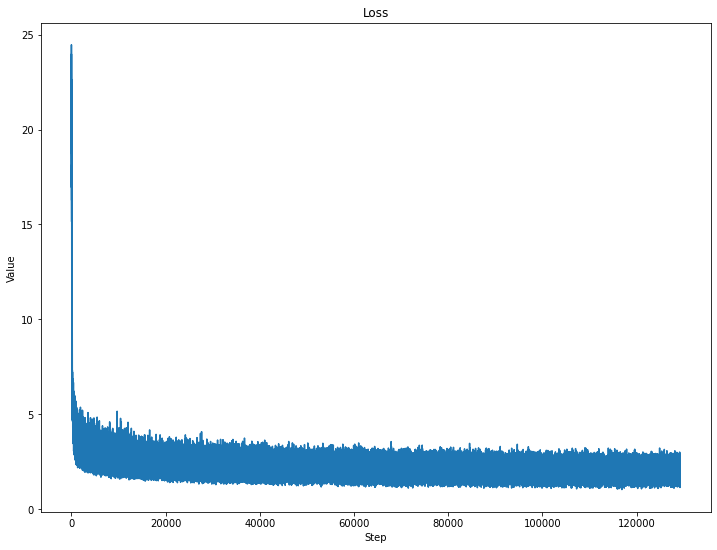

In [ ]:
# display training result
plt.figure(figsize=(12, 9))
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Value")
plt.plot(batch_loss_history[:])

In [ ]:
length = 250

In [ ]:
moving_average_loss = []
for i in range(length, len(batch_loss_history)):
    lst = batch_loss_history[i-length:i]
    mu = sum(lst) / len(lst)
    moving_average_loss.append(mu)

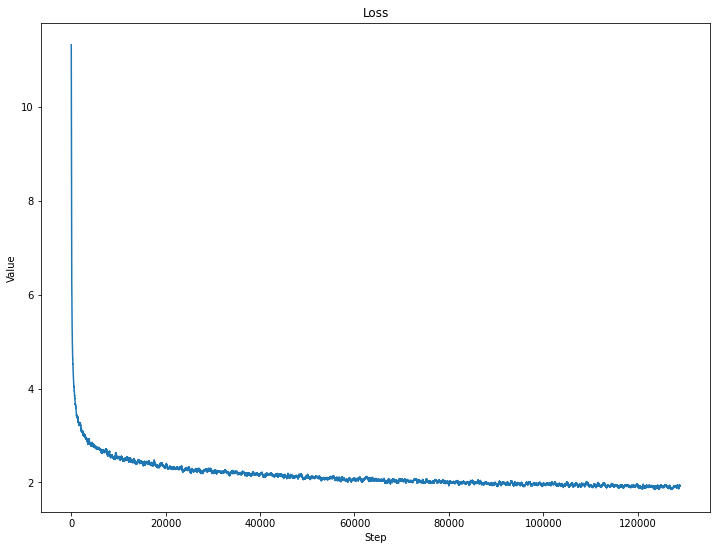

In [ ]:
# display training result
plt.figure(figsize=(12, 9))
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Value")
plt.plot(moving_average_loss)

In [ ]:
import pandas as pd

In [ ]:
df = {'loss': batch_loss_history}  
df = pd.DataFrame(df) 
# saving the dataframe 
df.to_csv('/gdrive/MyDrive/Classical_Music_Transformer_Integration/log/loss.csv') 